In [1]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import collections
import random
import time
pd.set_option('display.max_colwidth', None)

Get info of all metrics implemented

In [2]:
metrics = []
try:
    request = requests.get('http://seprojects.marum.de:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('marvel2020', 'wonderwoman2020'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [3]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics.head()

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,"Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.",2
3,FsF-F3-01M,Metadata includes the identifier of the data it describes.,1
4,FsF-F4-01M,Metadata is offered in such a way that it can be retrieved programmatically.,2


Run FAIR assessment for a given identifier

In [4]:
identifier = 'https://doi.org/10.1594/PANGAEA.902843'

In [5]:
%%time
fuji_service = 'http://seprojects.marum.de:1071/fuji/api/v1/evaluate'
req = {'object_identifier':identifier, 'test_debug':True}
r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('marvel2020', 'wonderwoman2020'))
json_data = r.json()

CPU times: user 9.22 ms, sys: 0 ns, total: 9.22 ms
Wall time: 8.92 s


In [6]:
json_data

[{'id': 1,
  'metric_identifier': 'FsF-F1-01D',
  'metric_name': 'Data is assigned a globally unique identifier.',
  'output': {'guid': 'https://doi.org/10.1594/PANGAEA.902843',
   'guid_scheme': 'doi'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ["INFO: Unique identifier schemes found ['doi', 'url']",
   'INFO: Finalized unique identifier scheme - doi'],
  'test_status': 'pass'},
 {'id': 2,
  'metric_identifier': 'FsF-F1-02D',
  'metric_name': 'Data is assigned a persistent identifier.',
  'output': {'pid': 'https://doi.org/10.1594/PANGAEA.902843',
   'pid_scheme': 'doi',
   'resolvable_status': True,
   'resolved_url': 'https://doi.pangaea.de/10.1594/PANGAEA.902843'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ['INFO: Persistence identifier scheme - doi',
   'INFO: Retrieving page http://doi.org/10.1594/PANGAEA.902843',
   'INFO: Content negotiation accept=text/html, application/xhtml+xml, status=200',
   'INFO: Found HTML page!',
   'INFO: Object identifier act

In [232]:
def process_json(json_data):
    earned = OrderedDict()
    totals =OrderedDict()
    # results['identifier'] = identifier

    for d in json_data:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        if not sub_principle in earned:
            earned[sub_principle] = d['score']['earned']
            totals[sub_principle] = d['score']['total']
        else:
            earned[sub_principle] += d['score']['earned']
            totals[sub_principle] += d['score']['total']
    
    earned_arr=list(earned.values())
    total_arr=list(totals.values())
    labels=list(earned.keys())
    
    return earned_arr,total_arr,labels

In [224]:
process_json(json_data)

([2, 2, 1, 2, 1, 2, 1, 3, 1, 1, 2],
 [2, 2, 1, 2, 1, 3, 1, 4, 1, 2, 2],
 ['F1', 'F2', 'F3', 'F4', 'A1', 'I1', 'I3', 'R1', 'R1.1', 'R1.2', 'R1.3'])

In [301]:
def color_generator(colormap,earned_arr,total_arr,labels,opacity=True):
    '''
     DESCRIPTION
         generate colors for inner (F1,F2,I1,R1,..) and outer ring (F,A,I,R) of pie chart 
     INPUT
         main_dict - dictionary, with several 1st level keys F,A,I,R value 
                     of each key is a dictionary itself, containing corresponding 2nd level elements 
         col_index1 (integer) - defines the width of outer ring colorband
     OUTPUT
         colors - dictionary with mapped colors 
    '''
    if opacity:
        percentages=[earned_arr[i]/total_arr[i] for i in range(len(total_arr))]
        percentages
    else:
        percentages=[1 for i in range(len(total_arr))]
    
    col_index1=50
    #get number of nececessary colors corresponding to 
    # number of 2nd level elements (F1,F2,..) for every 1st level element (F)
    ncolors=[]
    
    for key in ['F','A','I','R']:
        count=0
        for i in range(len(labels)):
            if key in labels[i]:
                count+=1
        ncolors.append(count)
                
    
    # generate outer colors 
    n_inner_colors=4
    cmap = plt.get_cmap(colormap)
    inner_colors=np.arange(1,n_outer_colors+1)*col_index1
    inner_colors_mapped=cmap(inner_colors)
    
    # generate inner colors based on outer colors 
    outer_colors=[]
    for i in range(n_inner_colors):
        color_arr=np.arange(ncolors[i])*0+inner_colors[i]
        outer_colors.append(color_arr)
        
    outer_arr=np.concatenate(outer_colors)  
    outer_arr_mapped=cmap(outer_arr)
    outer_arr_mapped[:,3]=percentages
    
    
    return inner_colors_mapped,outer_arr_mapped

In [318]:
###############
# Main function
###############

def metrics_pie_plot(json_data):
    '''
    DECSRIPTION
        processes input data, then plots the pie chart for FAIR metrics
    INPUT
        results dictionary,containing processed json data (dataset metrics)
        main_keys - list, contatining main metrics names e.g. ['F','A','I','R']
    OUTPUT
        ax - matplotlib.axes._subplots.AxesSubplot object 
    '''
    
    
    earned_arr,total_arr,labels=process_json(json_data)
    # generate colors for inner (F1,F2,I1,R1,..) and outer ring (F,A,I,R) of pie chart
    inner_colors,outer_colors=color_generator('plasma',earned_arr,total_arr,labels,opacity=True)

    #PLOTTING
    fig, ax = plt.subplots(figsize=(9,9))
    size = 0.3

    # OUTER RING
    ax.pie(total_arr, radius=1.1, colors=outer_colors,labels=labels,
           labeldistance=0.8,wedgeprops=dict(width=size, edgecolor='w'),counterclock=False,
           startangle=90,rotatelabels=True)
    
   
    
#     # MIDDLE RING2
#     inner_colors,outer_colors=color_generator('plasma',earned_arr,total_arr,labels,opacity=False)
#     ax.pie(total_arr, radius=0.75, colors=outer_colors,
#            labeldistance=0.7,wedgeprops=dict(width=size, edgecolor='w'),counterclock=False,
#            startangle=90,rotatelabels=True)
    
    #INNER RING
    patches, texts=ax.pie([1,1,1,1], radius=0.5, colors=inner_colors,labels=['F','A','I','R'],
          labeldistance=0.7, wedgeprops=dict(width=size, edgecolor='w'),counterclock=False,startangle=90)

    # increase the size of the labels
    [text.set_fontsize(18) for text in texts]

    return ax

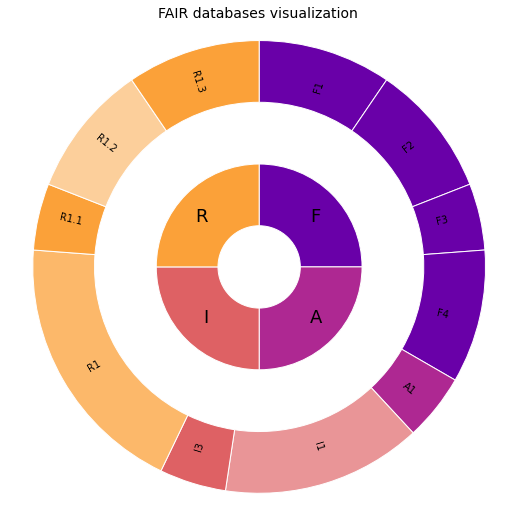

In [319]:
metrics_pie_plot(json_data)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("FAIR databases visualization",fontsize=14)
plt.show()

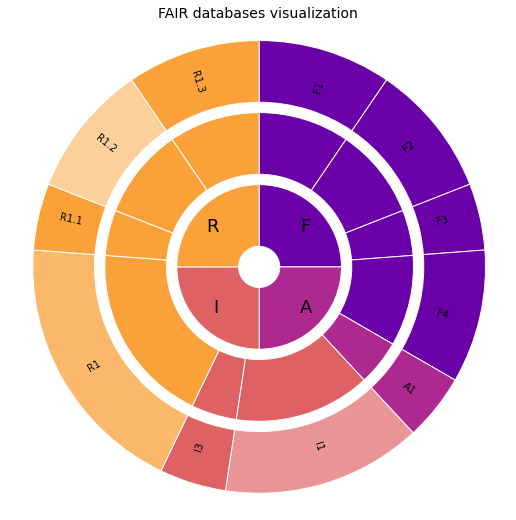

In [313]:
metrics_pie_plot(json_data)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("FAIR databases visualization",fontsize=14)
plt.show()

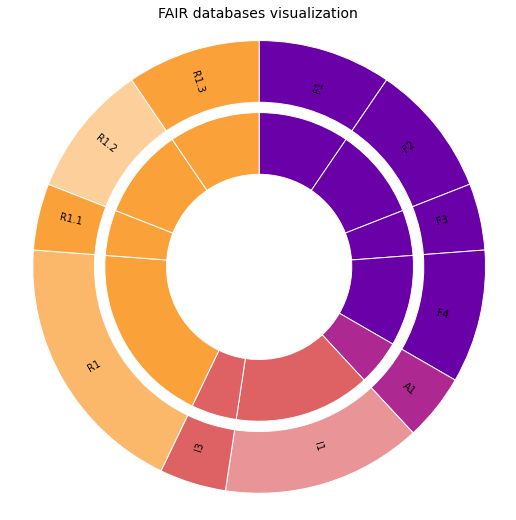

In [287]:
metrics_pie_plot(json_data)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("FAIR databases visualization",fontsize=14)
plt.show()